# Principal propagating direction in the human fMRI signals

In [14]:
import numpy as np
from scipy import io
from scipy.io import savemat
from scipy.signal import find_peaks
import pandas as pd
import matplotlib.pyplot as plt

def loadMat(path,name):
    mat_file1 = io.loadmat(path)
    data = mat_file1[name]
    return data

def prctile(data,start,interval,end):
    prctile = np.array([])
    percentage = start
    while(percentage <= 100):
        prctile = np.append(prctile,np.percentile(data,percentage))
        percentage += interval
    return prctile

def grpstats(epi,pgd1):
    max = np.max(pgd1)
    min = np.min(pgd1)
    result = np.empty((max-min+1 ,epi.shape[1]),object)
    nVtxInBin = np.zeros(max-min+1) # the number of vertices in each bin (1->70)
    for i in range(pgd1.size):
        nVtxInBin[pgd1[i]-1] +=1
        if(result[pgd1[i]-1][0] == None):
            temp = epi[i,:]
        else:
            temp = result[pgd1[i]-1,:] + epi[i,:]
        result[pgd1[i]-1,:] = temp
    for j in range(max-min+1):
        result[j,:] = result[j,:]/ nVtxInBin[j]
    return result

def findPeaks(data):
    locs = find_peaks(data)[0]
    peak = np.array([])
    for i in range(locs.size):
        peak = np.append(peak,data[locs[i]]) 
    return peak,locs

def inpaintNans(array):
    if np.isnan(array[0]):
        array[0] = array[1]
    if np.isnan(array[-1]):
        array[-1] = array[-2]
    df = pd.DataFrame(array.astype(np.float)).interpolate()
    return df.to_numpy()

## Load data

- **pg1:** principal gradient 1 by Margulies et al, PNAS, 2016

- **epi:** rsfMRI -> spatially & temporally smoothed -> zscored data *(vertices * time points)*

In [5]:
path ="/hdd_ext/sdc/class/2021-2/advancedfMRI/data/human/test"

pg1 = loadMat(path+"/pg1","pg1") # Margulies et al, PNAS, 2016
epi = loadMat(path+"/epi1msk","epi1msk") # spatially & temporally smoothed -> zscored data (vertices * time points)

## Global mean signal

Calculate **global mean signal** and identify **time segments** with a relatively large global positive peak amplitude

In [6]:
# calculate delay profile across time segments: idx_dly

global_mean_sig = epi.mean(axis=0) # calculate the global mean of input data - Figure 1B middle graph
locs_seg_edge = find_peaks(-1 * global_mean_sig)[0] # cut the global mean signal into time segments - Figure 2A upper graph
locs_global_peaks = find_peaks(global_mean_sig)[0] # find global mean signal peak

## Make a delay matrix

<img src="img/PD1.png" width="900" height="400"/>

Compute a delay profile at each vertex as the **relative time delay of the local peak** respect to the global peak

In [7]:
delay_mat = np.zeros((epi.shape[0], locs_seg_edge.shape[0]-1),object) # delay matrix: vertices * segments

for li in np.arange(locs_seg_edge.shape[0]-1):
    tmp_seg = np.array([]) 
    tmp_seg = epi[:,locs_seg_edge[li]:locs_seg_edge[li+1]] # get one time segment

    # locate max peaks in each vertex
    for lj in np.arange(epi.shape[0]):
        tmp_vertex = tmp_seg[lj,:] # get one vertex in one time segment
        value_vertex_peak, locs_vertex_peak = findPeaks(tmp_vertex) # and find peak of that vertex - Figure 2A Delay profile #1
        # value_vertex_peak: the value of each peak
        # locs_vertex_peak: index of the peak in each 

        threshold = 0

        # find location of largest peak in each vertex
        if locs_vertex_peak.size == 0: # if no peak
            delay_mat[lj,li] = np.NaN; # nan

        elif locs_vertex_peak.shape[0] > 1: # if more than one peaks exist
            value_max = np.max(value_vertex_peak) # pick just one peak that has the highest value
            idx_max = np.argmax(value_vertex_peak) 

            if value_max <= threshold: # if the peak value is lower than the threshold value,
                delay_mat[lj,li] = np.NaN; # nan
            else: # if the peak value is above the threshold value,
                delay_mat[lj,li] = locs_vertex_peak[idx_max] - (locs_global_peaks[li] - locs_seg_edge[li]) # save the index of the peak (as a relative index to the global peak)

        elif value_vertex_peak > threshold: # one peak, and above the threshold
            delay_mat[lj,li] = locs_vertex_peak[0] - (locs_global_peaks[li] - locs_seg_edge[li]) # save the index of the peak (as a relative index to the global peak)
        else :
            delay_mat[lj,li] = np.NaN

## applying SVD on delay profiles to calculate the principal delay profile: pd

## Filter delay matrix

Remove time segments in which more than 20% vertices don't have local peaks

In [8]:
delay_mat_filtered = np.array([])
for li in np.arange(delay_mat.shape[1]): # for the number of segments
    tmp_seg_delay = delay_mat[:,li] # all vertices of one segment
    if np.sum(np.isnan(tmp_seg_delay.astype(np.float))) < delay_mat.shape[0] * 0.2: # if the number of nan vertices in the segment is lower than 20%,
        if delay_mat_filtered.shape[0] == 0:
            delay_mat_filtered = inpaintNans(tmp_seg_delay)
        else:
            delay_mat_filtered = np.concatenate((delay_mat_filtered, inpaintNans(tmp_seg_delay)),axis=1) # fill nan with neighbor average and save it to the delay matrix

## Make principle delay(PD) profile by SVD

<img src="img/PD2.png" width="400" height="400"/>

$X=USV^T$

- PD profile: the **first column of U**, which explains the largest variance of X

In [12]:
U,S,V = np.linalg.svd(delay_mat_filtered, full_matrices = True)

pd1 = U[:, 1] # PD profile: the first column of U, which explains the largest variance of X

# variance explained for each components
temp = np.diag(S)
var_exp = temp**2/np.sum(temp**2)
print(var_exp)

[[0.25958266 0.         0.         ... 0.         0.         0.        ]
 [0.         0.08354049 0.         ... 0.         0.         0.        ]
 [0.         0.         0.07598427 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00659054 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00573214 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00547243]]


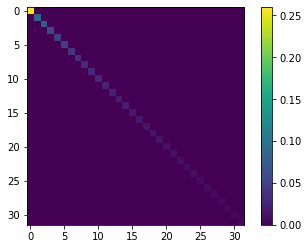

In [18]:
plt.imshow(var_exp)
plt.colorbar()
plt.show()

# Projecting the rsfMRI Signals Onto the PD profile direction

Same procedures as the projection onto the PG direction

In [15]:
pd1_70bins = np.digitize(pd1, prctile(pd1,0,100/70,100)) # divide pd1 vertices into 70 bins (vertices * 1 - the value in each row indicates which bin the vertex belongs to)
pd1_70bins = pd1_70bins-np.min(pd1_70bins)+1 # make sure that pd1_70bins values are in 1~70

# randomly rotated PG
rand_idx = np.random.permutation(pd1_70bins.shape[0])
pd1_70bins_rand = pd1_70bins[rand_idx.T]

time_pos = grpstats(epi, pd1_70bins)  # % the time-position plot (time_pos) along the brain map (postion(70) * time(1200)) - Figure 1B upper graph
time_pos_rand = grpstats(epi, pd1_70bins_rand) 

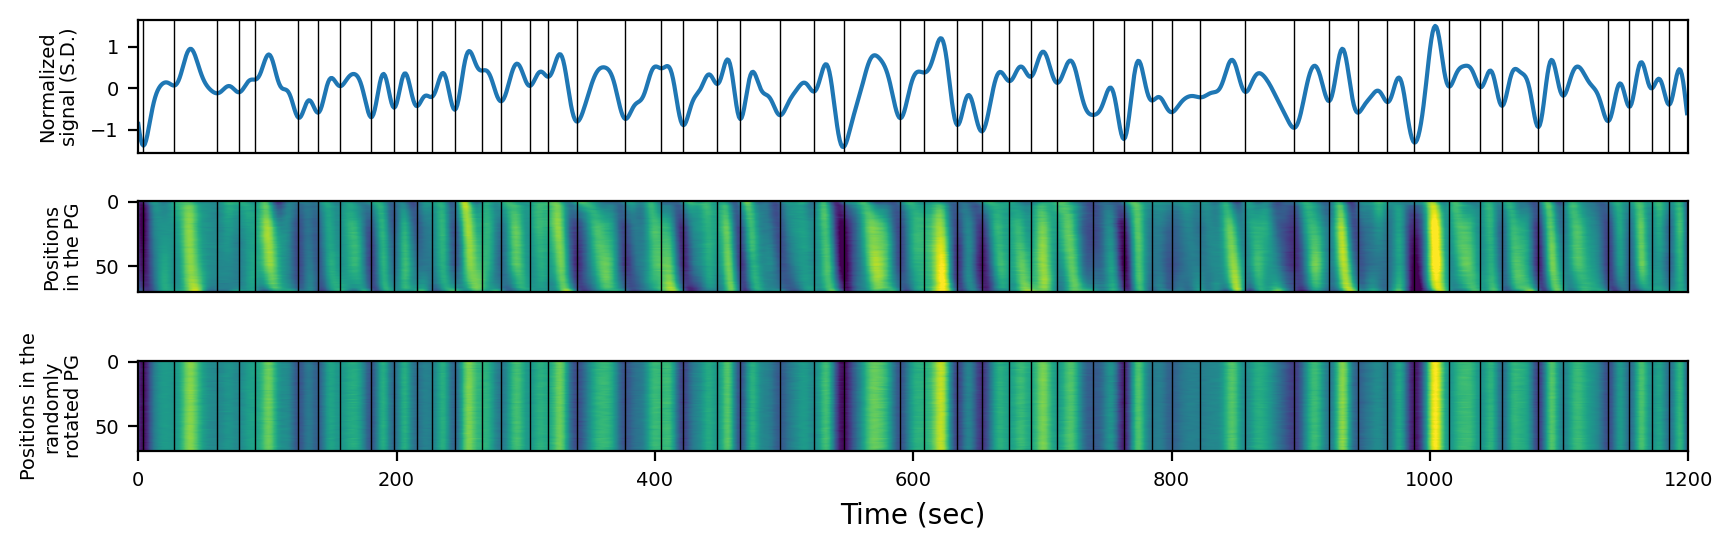

In [16]:
font_small = 7

fig, ax = plt.subplots(3, 1)

fig.set_size_inches(10,3)
fig.patch.set_facecolor('white')
fig.set_dpi(200)

# global mean signal graph
ax[0].plot(np.arange(global_mean_sig.shape[0]), global_mean_sig)
ax[0].set_ylabel('Normalized\nsignal (S.D.)', fontsize=font_small)
ax[0].set_xlim(0, 1200)
ax[0].tick_params (axis = 'y', labelsize = font_small)
ax[0].get_xaxis().set_visible(False)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[0].axvline(x=loc_now, color='k', linewidth=0.5)
    
# time-position graph
ax[1].imshow(time_pos.astype(np.float), vmin=-1.5, vmax=1.5)
ax[1].set_ylabel('Positions\nin the PG', fontsize=font_small)
ax[1].set_xlim(0, 1200)
ax[1].tick_params (axis = 'y', labelsize = font_small)
ax[1].get_xaxis().set_visible(False)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[1].axvline(x=loc_now, color='k', linewidth=0.5)
    
# time-position graph - randomly rotated PG
pos = ax[2].imshow(time_pos_rand.astype(np.float), vmin=-1.5, vmax=1.5)
ax[2].set_ylabel('Positions in the\nrandomly\nrotated PG', fontsize=font_small)
ax[2].set_xlim(0, 1200)
ax[2].tick_params (axis = 'y', labelsize = font_small)
ax[2].tick_params (axis = 'x', labelsize = font_small)
for i in range(locs_seg_edge.shape[0]):
    loc_now = locs_seg_edge[i]
    ax[2].axvline(x=loc_now, color='k', linewidth=0.5)
    
#plt.colorbar(pos, ax=ax[2], orientation='horizontal')

plt.xlabel('Time (sec)')
plt.show()

## Correlation between PD and PG

<img src="img/PD3.png" width="900" height="400"/>

In [19]:
pg1 = loadMat(path+"/pg1","pg1") # principle gradient 1 (vertices * 1)
pg1 = pg1.flatten()
r_btw_pd1_pg1 = np.corrcoef(pd1, pg1)[0,1]
print(r_btw_pd1_pg1)

-0.025159502503573475
